In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
def dirfiles(img_path, img_ext,full=False):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    return img_names

In [3]:
def equalizeHSV(hsv):
    Khsv = hsv.copy()
    Khsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    return Khsv

def laplacian(channel):
    laplacian = cv2.Laplacian(channel, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))
    
    _, smooth_mask = cv2.threshold(laplacian, 20, 255, cv2.THRESH_BINARY)
    image_cleaned = cv2.medianBlur(smooth_mask, 7) 
    
    return image_cleaned

def greenMask(hsv):
    lower_green = np.array([35, 50, 0])  # Light green
    upper_green = np.array([108, 254, 254])  # Dark green
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    return mask_green

def GLIMasktemp(image):
    red = image[:, :, 2].astype(float)
    green = image[:, :, 1].astype(float)
    blue = image[:, :, 0].astype(float)
    GLI = (2 * green - red - blue ) / (2* green + red + blue + 1e-6)

    GLI_normalized = cv2.normalize(GLI, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    GLI_normalized = cv2.medianBlur(GLI_normalized, 3)
    return GLI_normalized

def GLIMask(image):
    red = image[:, :, 2].astype(float)
    green = image[:, :, 1].astype(float)
    blue = image[:, :, 0].astype(float)
    
    # Calculate GLI
    GLI = (2 * green - red - blue) / (2 * green + red + blue + 1e-6)

    # Remove negative values
    GLI[GLI < 0] = 0

    # Normalize GLI
    GLI_normalized = cv2.normalize(GLI, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply median blur
    GLI_normalized = cv2.medianBlur(GLI_normalized, 3)
    
    return GLI_normalized

def validateContours(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(mask)
    
    image_area = final_mask.shape[0] * final_mask.shape[1]

    valid_contours = []
    prediction = False

    total_valid_contour_area = 0
    # Iterate over contours
    for contour in contours:
        # Calculate contour properties
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0
        inverse_aspect_ratio = float(h) / w if w > 0 else 0
        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        bounding_box_area = w * h
        fill_ratio = area / bounding_box_area if bounding_box_area > 0 else 0

        # Filter contours based on properties
        if (area >= 500 and
                aspect_ratio <= 3.0 and
                inverse_aspect_ratio <= 3.0 and
                fill_ratio > 0.2 and 
                circularity < 0.4):
            valid_contours.append(contour)  # Add valid contour to list
            total_valid_contour_area += area

    # If there are valid contours, draw them on the final mask
    if total_valid_contour_area >= 0.2 * image_area:
        for contour in valid_contours:
            prediction = True
            cv2.drawContours(final_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    return final_mask, prediction

def highlightImage(image, final_mask):
    red_image = np.zeros_like(image, dtype=np.uint8)
    red_image[:, :] = [255, 0, 0]

    masked_red = cv2.bitwise_and(red_image, red_image, mask=final_mask)

    highlighted_image = cv2.addWeighted(image, 1.0, masked_red, 0.2, 0)

    return highlighted_image

In [4]:
def ImageProcess(image, eq= False):
    # 1. Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 2. Equalize HSV
    hsv = equalizeHSV(hsv)

    h_channel = hsv[:, :, 0]  # Hue Channel
    s_channel = hsv[:, :, 1]  # Saturation Channel
    v_channel = hsv[:, :, 2]  # Value Channel (Brightness)
    
    # 3. Apply Laplacian filter to detect textures
    image_cleaned = laplacian(v_channel)

    # 4. Create green mask
    mask_green = greenMask(hsv)
    
    # 5. Create GLI mask
    GLI = GLIMask(image)

    GLI_mean = np.mean(GLI)
    
    # 6. Combine masks and apply contour filtering
    _, GLI_mask = cv2.threshold(GLI, GLI_mean, 255, cv2.THRESH_BINARY)
    combined_mask = cv2.bitwise_and(mask_green, image_cleaned) 
    combined_mask = cv2.bitwise_and(combined_mask, GLI_mask)

    final_result, prediction = validateContours(combined_mask)    

    return final_result, prediction


In [5]:
data_folder = '../data'

In [6]:
wildfire = dirfiles(data_folder + '/test/wildfire/', '*.jpg', full=True)
nowildfire = dirfiles(data_folder + "/test/nowildfire/", '*.jpg', full=True)

## Example case with step-by-step visualization

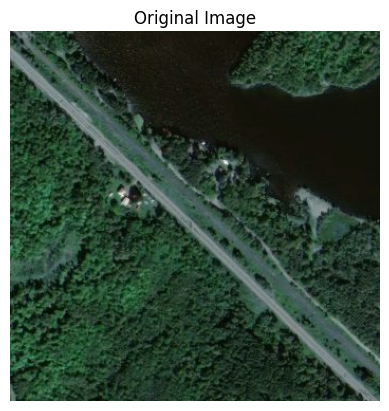

True

In [7]:
image = cv2.imread(data_folder + "/test/wildfire/-68.92161,47.39808.jpg")

plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

save_path = "../example/original_image.png"
cv2.imwrite(save_path, image)

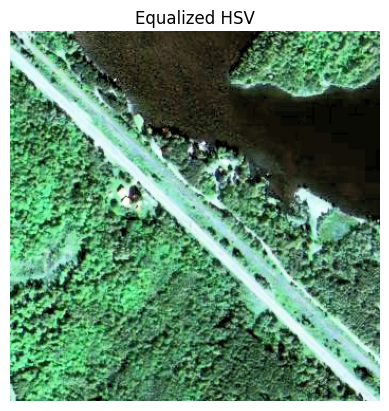

True

In [8]:
# 1. Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# 2. Equalize HSV
hsv = equalizeHSV(hsv)
hsv_to_show = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
plt.imshow(hsv_to_show)

plt.title("Equalized HSV")
plt.axis('off')
plt.show()
save_path = "../example/equalized_hsv.png"
cv2.imwrite(save_path, hsv_to_show)

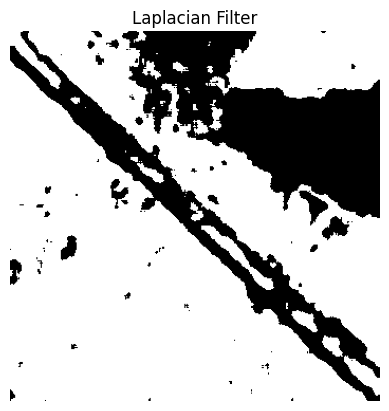

True

In [9]:
h_channel = hsv[:, :, 0]  # Canal Hue
s_channel = hsv[:, :, 1]  # Canal Saturation
v_channel = hsv[:, :, 2]  # Canal Value (Brillo)

# 3. Apply Laplacian filter to detect textures
image_cleaned = laplacian(v_channel)

plt.imshow(image_cleaned, cmap='gray')
plt.title("Laplacian Filter")
plt.axis('off')
plt.show()
save_path = "../example/laplacian_filter.png"
cv2.imwrite(save_path, image_cleaned)

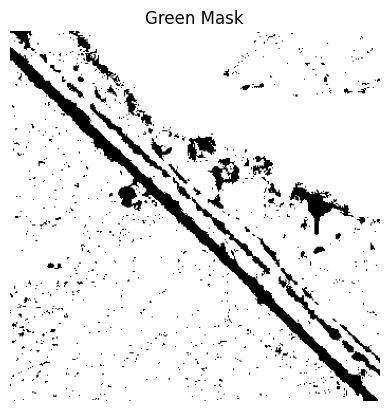

True

In [10]:
# 4. Create green mask
mask_green = greenMask(hsv)

plt.imshow(mask_green, cmap='gray')
plt.title("Green Mask")
plt.axis('off')
plt.show()
save_path = "../example/green_mask.png"
cv2.imwrite(save_path, mask_green)

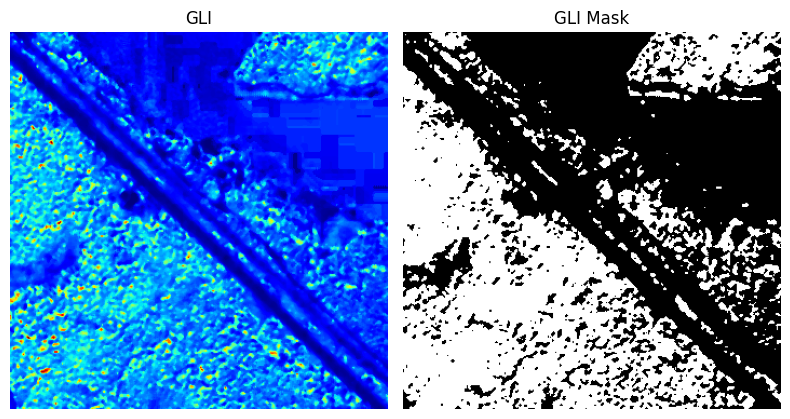

True

In [ ]:
# 5. Create GLI mask
GLI = GLIMask(image)

GLI_mean = np.mean(GLI)

_, GLI_mask = cv2.threshold(GLI, GLI_mean, 255, cv2.THRESH_BINARY)

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Show Result
axes[0].imshow(GLI, cmap='jet')
axes[0].set_title("GLI")
axes[0].axis('off')

axes[1].imshow(GLI_mask, cmap='gray')
axes[1].set_title("GLI Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

GLI_norm = cv2.normalize(GLI, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
GLI_color = cv2.applyColorMap(GLI_norm, cv2.COLORMAP_JET)
save_path = "../example/gli.png"
cv2.imwrite(save_path, GLI_color)
save_path = "../example/gli_mask.png"
cv2.imwrite(save_path, GLI_mask)

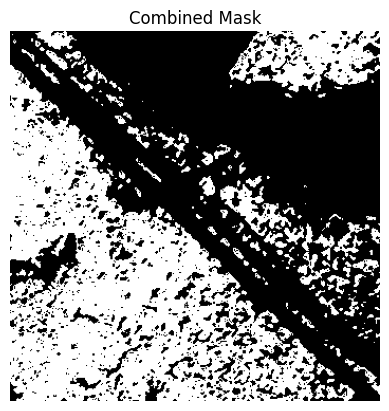

True

In [ ]:
# 6. Combine masks and apply contour filtering
combined_mask = cv2.bitwise_and(mask_green, image_cleaned) 
combined_mask = cv2.bitwise_and(combined_mask, GLI_mask)

plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask")
plt.axis('off')
plt.show()
save_path = "../example/combined_mask.png"
cv2.imwrite(save_path, combined_mask)

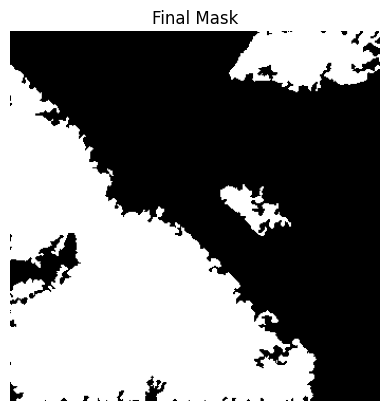

True

In [13]:

final_mask, prediction = validateContours(combined_mask)

plt.imshow(final_mask, cmap='gray')
plt.title("Final Mask")
plt.axis('off')
plt.show()
save_path = "../example/final_mask.png"
cv2.imwrite(save_path, final_mask)

Prediction: Fire-prone area


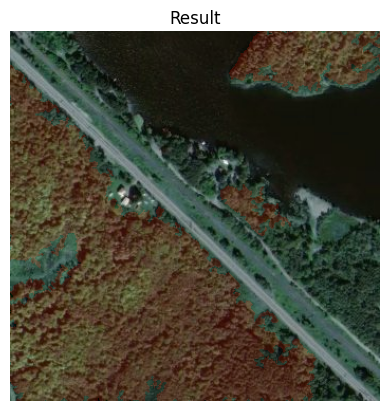

True

In [14]:
if prediction:
    prediction_text = "Fire-prone area"
else:
    prediction_text = "Non fire-prone area"


print(f"Prediction: {prediction_text}")

result = highlightImage(image, final_mask)

plt.imshow(result)
plt.title("Result")
plt.axis('off')
plt.show()
save_path = "../example/result.png"
cv2.imwrite(save_path, result)

## Results

In [15]:
# Real tags (1 = wildfire, 0 = no wildfire)
ground_truth = [1] * len(wildfire) + [0] * len(nowildfire)

# Predictions
predictions = []

# Process images from 'wildfire' (1)
for path in wildfire:
    image = cv2.imread(path)
    res, pred = ImageProcess(image)
    predictions.append(1 if pred else 0) 

# Process images from 'nowildfire' (0)
for path in nowildfire:
    image = cv2.imread(path)
    res, pred = ImageProcess(image)
    predictions.append(0 if not pred else 1)

Premature end of JPEG file


Total images: 6300

--- Metrics ---
Accuracy: 0.83
Precision: 0.84
Recall: 0.85
F1 Score: 0.84


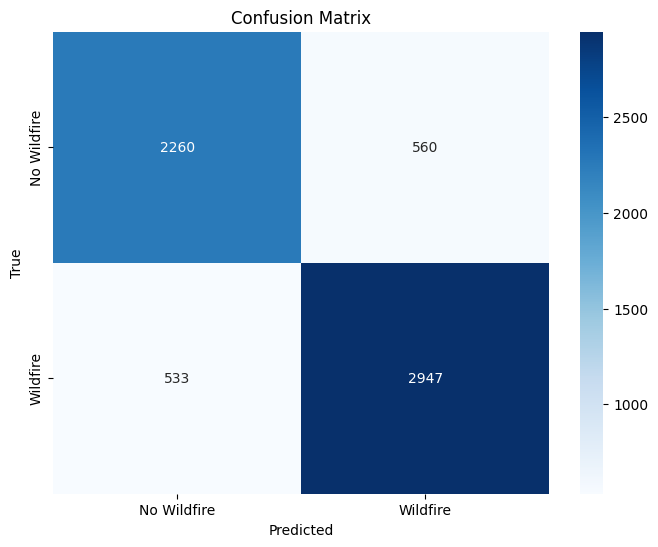

In [16]:
accuracy = accuracy_score(ground_truth, predictions)
precision = precision_score(ground_truth, predictions, zero_division=0)
recall = recall_score(ground_truth, predictions, zero_division=0)
f1 = f1_score(ground_truth, predictions, zero_division=0)
conf_matrix = confusion_matrix(ground_truth, predictions)

# Results
print(f"Total images: {len(nowildfire) + len(wildfire)}")
print("\n--- Metrics ---")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

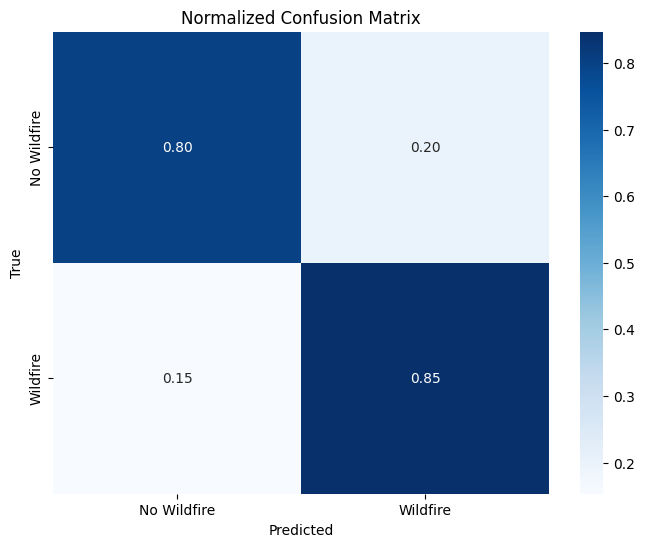

In [17]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()